# Lab 2b: Model selection
## Dark matter
We'll use the MAGIC telescope dataset (http://www.openml.org/d/1120). The task is to classifying gamma rays, which consist of high-energy particles. When they hit our atmosphere, they produce chain reactions of other particles called 'showers'. However, similar showers are also produced by other particles (hadrons). We want to be able to detect which ones originate from gamma rays and which ones come from background radiation. To do this, the observed shower patterns are observed and converted into 10 numeric features. You need to detect whether these are gamma rays or background radiation. This is a key aspect of research into dark matter, which is believed to generate such gamma rays. If we can detect where they occur, we can build a map of the origins of gamma radiation, and locate where dark matter may occur in the observed universe. However, we'll first need to accurately detect these gamma rays first.

A quick visualization of the features is shown below. Note that this is not a time series, we just plot the instances in the order they occur in the dataset. The first 12500 or so are examples of signal (gamma), the final 6700 or so are background (hadrons).

In [30]:
# General imports
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openml as oml
from matplotlib import cm

In [31]:
# Download MAGIC Telescope data from OpenML. You can repeat this analysis with any other OpenML classification dataset.
magic = oml.datasets.get_dataset(1120)
X, y, _, _ = magic.get_data(target=magic.default_target_attribute, dataset_format='array'); 
attribute_names = [f.name for i,f in magic.features.items()][:-1][1:]

C:\Users\loren\AppData\Local\Temp\ipykernel_11060\2616928666.py:3: FutureWarning: Support for `dataset_format='array'` will be removed in 0.15,start using `dataset_format='dataframe' to ensure your code will continue to work. You can use the dataframe's `to_numpy` function to continue using numpy arrays.
  X, y, _, _ = magic.get_data(target=magic.default_target_attribute, dataset_format='array');


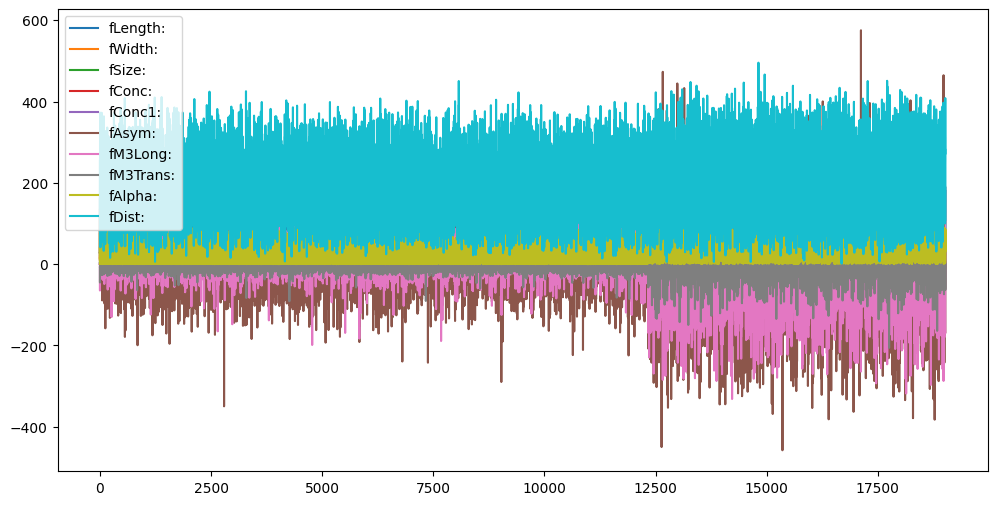

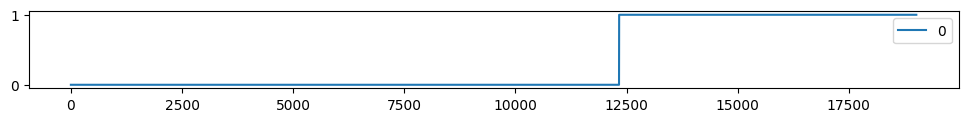

In [32]:
# Quick visualization of the features (top) and the target (bottom)
magic_df = pd.DataFrame(X, columns=attribute_names)
magic_df.plot(figsize=(12,6))
# Also plot the target: 1 = background, 0 = gamma
pd.DataFrame(y).plot(figsize=(12,1));

## Exercise 1: Metrics
Train and evaluate an SVM with RBF kernel (default hyperparameters) using a standard 25% holdout. Report the accuracy, precision, recall, F1 score, and area under the ROC curve (AUC).

Answer the following questions:
* How many of the detected gamma rays are actually real gamma rays?
* How many of all the gamma rays are we detecting?
* How many false positives and false negatives occur?

In [33]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)
model = SVC().fit(X_train, y_train)
y_pred = model.predict(X_test)
print("confusion_matrix(y_test, y_pred): \n", confusion_matrix(y_test, y_pred))
print("accuracy_score(y_test, y_pred): ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("AUC: {:.3f}".format(roc_auc_score(y_test, y_pred)))

confusion_matrix(y_test, y_pred): 
 [[2948  135]
 [ 700  972]]
accuracy_score(y_test, y_pred):  0.8243953732912723
              precision    recall  f1-score   support

           0       0.81      0.96      0.88      3083
           1       0.88      0.58      0.70      1672

    accuracy                           0.82      4755
   macro avg       0.84      0.77      0.79      4755
weighted avg       0.83      0.82      0.81      4755

AUC: 0.769


Detected gamma rays that are actually real gamma rays: 0.88 -> precision

Gamma rays detected: 0.58 -> recall

False positives: 135
False negatives: 700

## Exercise 2: Preprocessing
SVMs require scaling to perform well. For now, use the following code to scale the data (we'll get back to this in the lab about preprocessing and pipelines). Repeat question 2 on the scaled data. Have the results improved? 

In [34]:
from sklearn.preprocessing import StandardScaler
# Important here is to fit the scaler on the training data alone
# Then, use it to scale both the training set and test set
# This assumes that you named your training set X_train. Adapt if needed.
scaler = StandardScaler().fit(X_train)
Xs_train = scaler.transform(X_train)
Xs_test = scaler.transform(X_test)

In [35]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix

fitted_model = SVC().fit(Xs_train, y_train)
y_pred = fitted_model.predict(Xs_test)
print("confusion_matrix(y_test, y_pred): \n", confusion_matrix(y_test, y_pred))
print("accuracy_score(y_test, y_pred): ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("AUC: {:.3f}".format(roc_auc_score(y_test, y_pred)))

confusion_matrix(y_test, y_pred): 
 [[2956  127]
 [ 483 1189]]
accuracy_score(y_test, y_pred):  0.8717139852786541
              precision    recall  f1-score   support

           0       0.86      0.96      0.91      3083
           1       0.90      0.71      0.80      1672

    accuracy                           0.87      4755
   macro avg       0.88      0.83      0.85      4755
weighted avg       0.88      0.87      0.87      4755

AUC: 0.835


Detected gamma rays that are actually real gamma rays: 0.9 -> precision

Gamma rays detected: 0.71 -> recall

False positives: 127
False negatives: 483

Results seem much better

## Exercise 3: Hyperparameter optimization
Use 50 iterations of random search to tune the $C$ and $gamma$ hyperparameters on the scaled training data. Vary both on a log scale (e.g. from 2^-12 to 2^12). 

Optimize on AUC and use 3 cross-validation (CV) folds for the inner CV to estimate performance. For the outer loop, just use the train-test split you used before (hence, no nested CV). Report the best hyperparameters and the corresponding AUC score. Is it better than the default? Finally, use them to evaluate the model on the held-out test set, for all 5 metrics we used before.

Extra challenge: plot the samples used by the random search ($C$ vs $gamma$)

Note: The reason we don't use a nested CV just yet is because we would need to rebuild the scaled training and test set multiple times. This is tedious, unless we use pipelines, which we'll cover in a future lab.

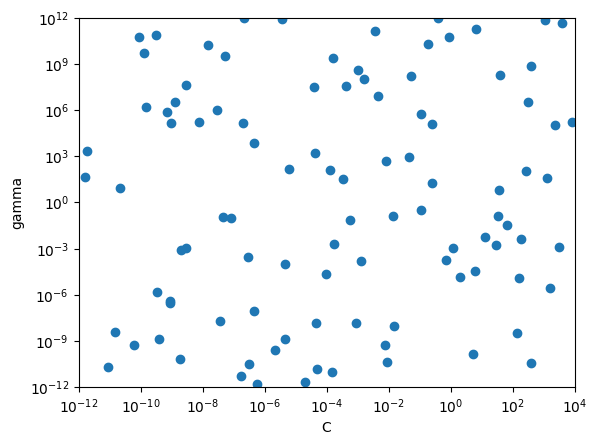

In [36]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform

param_grid = {'C': loguniform(1e-12, 1e4).rvs(size=100), 
              'gamma': loguniform(1e-12, 1e12).rvs(size=100)}

fig, ax = plt.subplots()
ax.scatter(param_grid['C'],param_grid['gamma'])
ax.set_xlabel("C")
ax.set_ylabel("gamma")
ax.set_xlim(1e-12, 1e4)
ax.set_ylim(1e-12, 1e12)
ax.set_xscale('log')
ax.set_yscale('log')

In [38]:
random_search = RandomizedSearchCV(SVC(), param_distributions=param_grid, n_iter=50, 
                                   cv=3, scoring='roc_auc', verbose=2, n_jobs=-1)
random_search.fit(Xs_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3, estimator=SVC(), n_iter=50, n_jobs=-1,
                   param_distributions={'C': array([8.94235251e-04, 5.31191170e+00, 3.98015296e+02, 3.63974996e-06,
       5.17625046e-08, 4.63161927e-07, 3.89485058e-01, 8.93783316e-10,
       8.35830682e-03, 2.93062652e-07, 2.86270771e-09, 3.44088491e-04,
       1.20090628e+00, 1.40951700e-02, 1.67564226e-04, 2.03498078e-05,
       3.17876272e-10, 7.1...
       1.65198478e+05, 1.31177153e-09, 3.08061971e-11, 4.17189529e+11,
       4.37784646e-03, 2.09096839e-11, 5.56858495e-10, 5.83878408e-10,
       5.95247743e+00, 1.54199374e-06, 1.39034051e-05, 1.82875487e-08,
       2.68488618e-06, 7.88999207e+05, 9.07193115e+02, 1.16155850e-01,
       5.60550366e-12, 1.57531914e-03, 1.33748639e+02, 1.58100844e-04,
       6.45385843e-11, 8.34635214e-04, 7.43408597e+03, 1.05589337e+02])},
                   scoring='roc_auc', verbose=2)

In [41]:
print("Best score: {:.4f}",random_search.best_score_)

Best score: {:.4f} 0.9191803872758002


AUC is better than before, but it is the score of the inner CV, not test set.

In [43]:
print("Default gamma: ",fitted_model._gamma)
print("Default C: ",fitted_model.C)

Default gamma:  0.10000000033436743
Default C:  1.0


qDefault gamma is similar to computed one, C is not.

In [44]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

# Get best estimator, train on the full training set, and evaluate on the test set
best_svm = random_search.best_estimator_.fit(Xs_train,y_train)
y_pred = best_svm.predict(Xs_test)

# Get the scores by comparing the predictions y_pred with the ground truth y_test
print("Accuracy: {:.3f}".format(accuracy_score(y_test, y_pred)))
print("Precision: {:.3f}".format(precision_score(y_test, y_pred)))
print("Recall: {:.3f}".format(recall_score(y_test, y_pred)))
print("F1 score: {:.3f}".format(f1_score(y_test, y_pred)))
print("AUC: {:.3f}".format(roc_auc_score(y_test, y_pred)))

Accuracy: 0.878
Precision: 0.912
Recall: 0.724
F1 score: 0.807
AUC: 0.843


The scores on the test set are slightly lower than we observed before. This likely means that we are overfitting the hyperparameters on the single train test split. Do keep in mind that the result on a single held out test set should be treated with care. It would be best to also do an outer CV to get a better estimate.

## Exercise 4: Threshold calibration
First, plot the Precision-Recall curve for the SVM using the default parameters on the scaled data. Then, calibrate the threshold to find a solution that yields better recall without sacrificing too much precision.

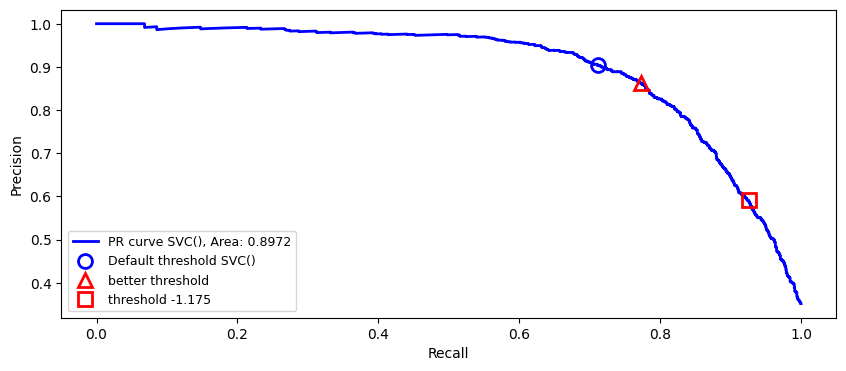

In [58]:
from sklearn.metrics import auc, precision_recall_curve
plt.figure(figsize=(10,4))


precision, recall, thresholds = precision_recall_curve(
    y_test, fitted_model.decision_function(Xs_test))
close_zero = np.argmin(np.abs(thresholds))
    
plt.plot(recall, precision, lw=2, c='b', label="PR curve {}, Area: {:.4f}".format(fitted_model, auc(recall, precision))) 
plt.plot(recall[close_zero], precision[close_zero], 'o', markersize=10,
            fillstyle="none", c='b', mew=2, label="Default threshold {}".format(fitted_model))

threshold = -0.28
close_t = np.argmin(np.abs(thresholds-threshold))
plt.plot(recall[close_t], precision[close_t], '^', markersize=10, label="better threshold", fillstyle="none", c='r', mew=2)

threshold = -1.175
close_t = np.argmin(np.abs(thresholds-threshold))
plt.plot(recall[close_t], precision[close_t], 's', markersize=10, label="threshold -1.175", fillstyle="none", c='r', mew=2)

plt.ylabel("Precision")
plt.xlabel("Recall")
plt.legend(loc="lower left", prop={"size":9})

The Precision-recall curve is really smooth. Every improvement in recall will equally reduce precision. We can move a little bit to the right. There is a small drop around threshold -0.28. That means we will be predicting more points as positive.

## Exercise 5: Cost function
Assume that a false negative is twice as bad (costly) than a false positive. I.e. we would rather waste time checking gamma ray sources that are not real, than missing an interesting gamma ray source. Use ROC analysis to find the optimal threshold under this assumption.

Finally, let the model make predictions using the optimal threshold and report all 5 scores. Is recall better now? Did we lose a lot of precision?

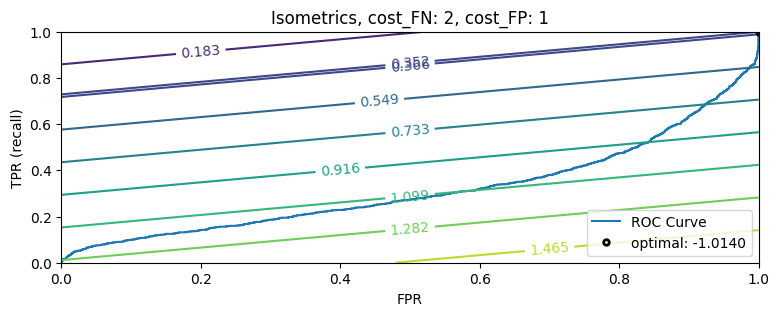

In [59]:
from sklearn.metrics import roc_curve

# Reusing code for the lecture notebook
# Cost function, give the cost for FN and FP
def cost(fpr, tpr, cost_FN, cost_FP, ratio_P):
    return fpr * cost_FP * ratio_P + (1 - tpr) * cost_FN * (1 - ratio_P)

def plot_isometrics(c_FN=2, c_FP=1):
    # Build the ROC curve for the trained model
    fpr, tpr, thresholds = roc_curve(y_test, model.decision_function(Xs_test))

    # Compute costs
    ratio_P = len(y_test[y_test==1]) / len(y_test)
    costs = [cost(fpr[x],tpr[x],c_FN,c_FP, ratio_P) for x in range(len(thresholds))]
    
    # Get optimal cost and threshold
    min_cost = np.min(costs)
    min_thres = np.argmin(costs)
    min_thres_val = thresholds[np.argmin(costs)]

    # plot contours
    x = np.arange(0.0, 1.1, 0.1)
    y = np.arange(0.0, 1.1, 0.1)
    XX, YY = np.meshgrid(x, y)
    costs = [cost(f, t, c_FN, c_FP, ratio_P) for f, t in zip(XX,YY)]

    # plot all together
    fig, axes = plt.subplots(1, 1, figsize=(9, 3))
    plt.plot(fpr, tpr, label="ROC Curve")
    levels = np.linspace(np.array(costs).min(), np.array(costs).max(), 10)
    levels = np.sort(np.append(levels, min_cost))
    CS = plt.contour(XX, YY, costs, levels)
    plt.clabel(CS, inline=1, fontsize=10)

    plt.xlabel("FPR")
    plt.ylabel("TPR (recall)")
    # find threshold closest to zero:
    plt.plot(fpr[min_thres], tpr[min_thres], 'o', markersize=4,
             label="optimal: {:.4f}".format(min_thres_val), fillstyle="none", c='k', mew=2)
    plt.legend(loc=4);
    plt.title("Isometrics, cost_FN: {}, cost_FP: {}".format(c_FN, c_FP))
    plt.show()
    
plot_isometrics()

In [60]:
y_pred = (model.decision_function(Xs_test) >= -1.175).astype(int)

# Get the scores by comparing the predictions y_pred with the ground truth y_test
print("Accuracy: {:.3f}".format(accuracy_score(y_test, y_pred)))
print("Precision: {:.3f}".format(precision_score(y_test, y_pred)))
print("Recall: {:.3f}".format(recall_score(y_test, y_pred)))
print("F1 score: {:.3f}".format(f1_score(y_test, y_pred)))
print("AUC: {:.3f}".format(roc_auc_score(y_test, y_pred)))

Accuracy: 0.352
Precision: 0.352
Recall: 1.000
F1 score: 0.520
AUC: 0.500


The recall score improved massively, but we also lost a lot of precision. If we plot this threshold in the precision-recall curve (see previous question), we see that it is indeed giving high recall but low precision. Accuracy and AUC also reduced quite a bit. However, if recall is what we really care about, this would still be a good solution.